<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_HR_gr1/blob/Vyimov-Zorislav-folder/Vyimov%20Zorislav/ZorislavVyymov_Internship_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Блокнот по Стажировке по задаче "Оценка кадидатов по резюме".**

## Текущие непонятки

### **По задаче Заказчика**

#### Ранее снятые вопросы

1. Верно ли: НС должна угадывать предпочтения Заказчика к соискателям по совокупности данных в тех резюме, которые он пометил как "Да" (подходит)? Применимо ко всем позициям (должностям) соискателей в датасете? 

Ответ: да

2. По ТЗ требуется оценить степень приемлемости кандидатов для компании, но разве для этого эта степень не должна входить в разметку датасета? Сейчас ее нет - откуда брать? Или эта степень будет выражаться вероятностью результата «подходит»?

Ответ: Нет, не должна. Да, степенью вероятности ответа да /нет

3. Верно ли, что те резюме, которые Заказчик никак не разметил (Поле "Подходит да/нет") никак нельзя использовать в обучении и их придется просто удалить из дататсета?

Ответ: верно, для обучения бесполезны.

#### Оставшиеся вопросы

1. Какова гарантия того, что Заказчик не изменит свои критерии оценки резюме со временем: при разметке руководствовался одними, при оценке нейронке и подготовки тестовых данных  - другими?  Не правильнее сразу выделить тестовые данные из размеченных Заказчиком (как только получим их) и сохранить их для оценки по готовности НС?

2. Пока не очень ясно, как обеспечить дообучаемость модели. Видимо, с заказчиком необходимо оговорить формат поставляемых им новых данных в будущем, с тем, чтобы автоматически производить их предобработку для подачи в НС с уже используемыми данными. Соответственно, стоит сразу выстраивать автопредобработку данных, применяемой к новым данным. Текущий дататсет можно взять за основу, если только Заказчик не намерен его изменить в будущем. Или получить от заказчика форму датасета в будущем. Если у заказчика нет какого то внятного видения этого будущего представления, возможно лучшим вариантом было бы предложить ему ту форму, которую он обязуется соблюдать при подготовке новых данных и которая максимально соответствовала бы решению задачи. Тогда автопредобработку надо выстраивать именно этого формата.

### **По ходу решения**




#### Ранее решенные 

1. ошибка при сборке вектора из обработанных данных с помощью отдельных функций для каждого поля 

Решено: выявлена неверная индексация столбцов названиями полей для использования в коде. Исправлено

2. ошибки в работе функций парсинга данных (не все варианты обрабатываются).

Решено: Исправлено.

3. Упустил категоризировать поле "целевая позиция" и включить в итоговый вектор.

Решено:  В набор предобработки включены соответствующие функции парсинга, в двух вариантах. Дополнены функции сборки даных в итоговый вектор для подачи в НС.

#### Не решенные

пока нет

## Сборник необходимых для работы библиотек.

In [138]:
# импортируем keras
from tensorflow import keras
from tensorflow.keras import layers

# Работа с массивами данных
import numpy as np 

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Для подключения Гугл-диска
from google.colab import drive

# Работа со временем
import time

# Чтоб рисовать в колабе:
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #

#from google.colab import files #  Для загрузки своей картинки

import random #Для генерации случайных чисел 
import math # Для округления

# Запись в файлы и чтение из файлов структур данных Python
# import pickle

#import os #Для работы с файлами 

# Регулярные выражения
import re 

from IPython.display import clear_output

## Исходные данные. Анализ

### Исследование Датасета

Скачаем базу для работы:

In [ ]:
# Чтение файла базы данных из сохраненного как CSV файла:
df = pd.read_csv('DataSet.csv', error_bad_lines=False)

# Вывод количества резюме и числа признаков
print(df.shape)

df.head()

Очень много потерянных при загрузке данных, если использовать этот способ загрузки. В данных - каша. Исправлять вручную - не вариант. Использую загрузку оригинального файла в формате .xlsx

---



In [ ]:
# Загрузим как файл .xlsx
data = pd.read_excel('ДатаСет Оценка резюме 581 резюме_без пуст.xlsx')
data

,Unnamed: 0,Дата отклика,ФИО,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,0,2023-02-23 00:00:00,Bessonova Mariya,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,1,2023-01-11 00:00:00,Ефремова Екатерина Вячеславовна,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2,2023-02-27 00:00:00,Фролов Артур Михайлович,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,Директор по маркетингу и бренд-менеджер,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,3,2023-01-11 00:00:00,Хозаев Расул Шагаманович,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,4,2023-01-11 00:00:00,Шадрин Олег Михайлович,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,2022-12-05 00:00:00,Царева Резида Юнировна,"Женщина, 33 года, родилась 21 апреля 1989",45 000 руб.,HR-специалист,"Уфа, Не готова к переезду, готова к редким ком...",полная занятость,"полный день, удаленная работа",Опыт работы —14 лет 1 месяц,Сбербанк,Старший менеджер по обслуживанию,"Высшее, 2013, Башкирский государственный униве...",4 марта 2023 в 19:58,нет
496,496,2023-02-08 00:00:00,Чёрная Соня,"Женщина, 21 год, родилась 8 марта 2002",30 000 руб.,HR-специалист,"Уфа, Не готова к переезду, не готова к команди...",полная занятость,"полный день, сменный график",Опыт работы —2 года 11 месяцев,Семейный доктор,Администратор,"Среднее специальное, 2021, Угктид",9 февраля 2023 в 10:08,нет
497,497,2023-02-03 00:00:00,Чуфарова Анастасия,"Женщина, 24 года, родилась 6 апреля 1998",не указана,HR-специалист,"Уфа, Не готова к переезду, не готова к команди...",полная занятость,полный день,Опыт работы —2 года 4 месяца,"Газпромбанк, ОАО",Специалист CRM-продаж,"Высшее, 2022, Уфимский государственный нефтяно...",17 января 2023 в 10:27,нет
498,498,2022-12-13 00:00:00,Шамсутдинова Айгуль Хуснулловна,"Женщина, 35 лет, родилась 28 декабря 1987",не указана,HR-специалист,"Уфа, Готова к переезду, готова к командировкам",полная занятость,полный день,Опыт работы —12 лет 2 месяца,"ООО ""Кардио-неврологический центр""",Администратор,"Высшее, 2016, ГБОУ ВО ""Башкирская академия гос...",16 декабря 2022 в 11:39,нет


Данные загружены и по нумерации строк видно, что фактически данных меньше: в XLS легко определить, что нет строк 541-543. 
Посмотрим на данные, с которыми нам предстоит работать:

In [ ]:
# Вывод количества резюме и числа признаков
print(data.shape)

data.head(3)

(579, 15)


,Unnamed: 0,Дата отклика,ФИО,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,0,2023-02-23 00:00:00,Bessonova Mariya,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,1,2023-01-11 00:00:00,Ефремова Екатерина Вячеславовна,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2,2023-02-27 00:00:00,Фролов Артур Михайлович,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,Директор по маркетингу и бренд-менеджер,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Unnamed: 0                       579 non-null    int64 
 1   Дата отклика                     579 non-null    object
 2   ФИО                              579 non-null    object
 3   Пол, возраст                     579 non-null    object
 4   ЗП                               579 non-null    object
 5   Ищет работу на должность         579 non-null    object
 6   Город                            579 non-null    object
 7   Занятость                        579 non-null    object
 8   График                           579 non-null    object
 9   Опыт ()                          579 non-null    object
 10  Последнее/нынешное место работы  579 non-null    object
 11  Последняя/нынешняя должность     579 non-null    object
 12  Образование и ВУЗ                579

Выводы: 
1. Целевой столбец не содержит данных для 79 записей.  Это вопрос к заказчику (их предоставление)
2. К удалению из ДФ как бесполезные данные для обучения: столбцы 0,1,2,10,13
3. Кажется целесообразным разбить данные S3 на отдельные признаки: "Пол" и "Возраст"
4. Кажется целесообразным разбить данные S12 на отдельные признаки "Образование" и "ВУЗ"

In [ ]:
# посмотрим на единственный цифровой столбец S0:
data.describe()

,Unnamed: 0
count,579.000000
mean,289.196891
std,167.607444
min,0.000000
25%,144.500000
50%,289.000000
75%,433.500000
max,581.000000


Сквозная нумерация строк отличается от нумерации в поле S0. Не хватает 3 строк. Предлагаю удалить этот столбец из DF data

In [ ]:
data.describe(include=['O'])

,Дата отклика,ФИО,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
count,579,579,579,579,579,579,579,579,579,579,579,579,579,500
unique,89,507,443,44,8,209,20,30,252,486,358,488,547,2
top,2023-02-22 00:00:00,ФИО скрыто соискателем,Женщина,не указана,Growth Product Manager,"Уфа, Не готова к переезду, не готова к команди...",полная занятость,полный день,Опыт работы —6 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product manager,Среднее образование,31 января 2023 в 09:52,нет
freq,48,7,41,288,198,69,342,202,10,12,42,15,3,489


In [ ]:
# посмотрим на столбец "Пол, возраст"
data["Пол, возраст"].value_counts()


Женщина                                       41
Мужчина                                       35
Женщина, 37 лет, родилась 3 января 1986        4
Мужчина, 28 лет, родился 16 августа 1994       4
Мужчина, 21 год, родился 8 марта 2001          3
                                              ..
Женщина, 26 лет, родилась 25 сентября 1996     1
Женщина, 22 года, родилась 17 июля 2000        1
Мужчина, 26 лет, родился 18 апреля 1996        1
Женщина, 27 лет, родилась 11 декабря 1995      1
Женщина, 29 лет, родилась 21 марта 1993        1
Name: Пол, возраст, Length: 443, dtype: int64

выводы: 
1. пол соискателя - обычно значимая информация для работодателя. нужно выводить в самостоятельный атрибут.
2. возраст соискателя - обычно значимая информация для работодателя, но в данном ДС она неполна для 76 записей. Нужно попытаться выделить ее в самостоятельный атрибут (int) и категоризировать, согласовать с Заказчиком категории. В отношении пустых значений предлагаемого нового атрибута "возраст" предлагаю заместить значением "нет данных". При категоризации это значение приравнять к 0, включив его, таким образом в первую категорию (0-17 лет)
3. дата рождения соискателя -  обычно не значимая при подборе информация и в данном случае не поможет восполнить недостающие значения атрибута "возраст". Но при устаревшем ДС она может дать более корректные знасения возраста (текущий год минус год рождения). К тому же, проще парсить четыре подряд идущих числовых символа - наверняка год. Дата и месяц рождения не интересны. По согласованию с Заказчиком предлагаю игнорить эти данные при обучении. Использовать только возраст.

In [ ]:
# Доля пустых значений в полях:
data.isna().sum() / data.shape[0]

Unnamed: 0                         0.000000
Дата отклика                       0.000000
ФИО                                0.000000
Пол, возраст                       0.000000
ЗП                                 0.000000
Ищет работу на должность           0.000000
Город                              0.000000
Занятость                          0.000000
График                             0.000000
Опыт ()                            0.000000
Последнее/нынешное место работы    0.000000
Последняя/нынешняя должность       0.000000
Образование и ВУЗ                  0.000000
Обновление резюме                  0.000000
Подходит - да/нет                  0.136442
dtype: float64

Новой информации это не дало. Разметка Датасета (заполненение подходит/не подходит) является обязательством заказчика - эти данные надо истребовать и перевести в булеву величину.



In [ ]:
# посмотрим на столбец "ЗП"
data["ЗП"].value_counts()

не указана       288
50 000 руб.       27
100 000 руб.      24
70 000 руб.       24
40 000 руб.       23
150 000 руб.      21
60 000 руб.       21
30 000 руб.       20
35 000 руб.       19
80 000 руб.       18
120 000 руб.      15
200 000 руб.       8
45 000 руб.        8
90 000 руб.        7
75 000 руб         5
180 000 руб.       4
110 000 руб.       4
95 000 руб.        3
55 000 руб.        3
85 000 руб.        3
20 000 руб.        3
65 000 руб.        2
1 550 USD          2
130 000 руб.       2
280 000 руб.       2
250 000 руб.       2
1 руб.             2
25 000 руб.        2
2 000 USD          2
100 000 KGS        1
155 000 руб.       1
170 000 руб.       1
3 500 USD          1
600 000 KZT        1
160 000 руб.       1
127 000 руб.       1
119 000 руб.       1
350 000 руб.       1
4 000 USD          1
2 500 USD          1
1 200 EUR          1
1 900 000 KZT      1
140 000 руб.       1
3 000 USD          1
Name: ЗП, dtype: int64

In [ ]:
data["ЗП"].unique()

array(['90 000 руб.', 'не указана', '150 000 руб.', '120 000 руб.',
       '100 000 руб.', '30 000 руб.', '40 000 руб.', '70 000 руб.',
       '50 000 руб.', '140 000 руб.', '130 000 руб.', '80 000 руб.',
       '65 000 руб.', '95 000 руб.', '45 000 руб.', '60 000 руб.',
       '200 000 руб.', '1 900 000 KZT', '1 руб.', '250 000 руб.',
       '280 000 руб.', '110 000 руб.', '600 000 KZT', '1 550 USD',
       '1 200 EUR', '2 500 USD', '85 000 руб.', '4 000 USD',
       '350 000 руб.', '119 000 руб.', '180 000 руб.', '127 000 руб.',
       '160 000 руб.', '2 000 USD', '3 500 USD', '75 000 руб',
       '170 000 руб.', '155 000 руб.', '55 000 руб.', '35 000 руб.',
       '20 000 руб.', '25 000 руб.', '100 000 KGS', '3 000 USD'],
      dtype=object)

Предложения:
1. перевести к единой валюту (руб) и только в числовые значения
2. Значения "1 руб" пусть преобразуется в 1 
3. не указана преобразовать в число 0
4. категорировать значения по согласованию с Заказчиком.

In [ ]:
data["Город"].value_counts()

Уфа, Не готова к переезду, не готова к командировкам                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              69
Уфа, Не готова к переезду, готова к редким командировкам                                           

Выводы:
1. предлагаю выделить в три отдельных атрибута:
 - до первой запятой: текстовый "Город"  и затем категоризировать: (город работодателя (Москва), Миллионники, Зарубеж, остальные)
 - от первой до посдедней запятой: булево "готов к переезду", где 1 принадлежит вариациям "готов к переезду" без конкретики ИЛИ
   "готов к переезду" + город/страна Работодателя;  0 == все остальное
 - после последней запятой: 3 категории "готов к командировкам": (нет, редкие, да)

In [ ]:
# рассмотрим содержимое колонки соискателя должности
data["Ищет работу на должность"].unique()

array(['Growth Product Manager',
       'Product manager в Growth Hacking команду',
       'Директор медицинской клиники', 'HR-специалист',
       'Product Manager в команду Финансового департамента',
       'Product Manager в команду HR', 'Project manager',
       'Product Marketing Manager в Growth Hacking команду'], dtype=object)

Вывод: не более 8 вариантов. Категоризировать.

In [ ]:
# рассмотрим содержимое колонки "Занятость"
data["Занятость"].unique()

array(['проектная работа, частичная занятость, полная занятость',
       'полная занятость',
       'стажировка, частичная занятость, полная занятость',
       'полная занятость, частичная занятость, проектная работа',
       'проектная работа, полная занятость',
       'проектная работа, стажировка, волонтерство, частичная занятость, полная занятость',
       'проектная работа, стажировка, частичная занятость, полная занятость',
       'частичная занятость, полная занятость',
       'проектная работа, стажировка, полная занятость',
       'стажировка, полная занятость', 'частичная занятость',
       'проектная работа, неполный рабочий день, полный рабочий день',
       'проектная работа, частичная занятость',
       'полная занятость, частичная занятость, проектная работа, стажировка',
       'проектная работа, волонтерство, частичная занятость, полная занятость',
       'полная занятость, проектная работа',
       'полная занятость, частичная занятость',
       'полная занятость, час

Вывод: 
1. по согласованию с заказчиком исключить вариант "волонтерство", если он ему не интересен/оставить
2. неполный рабочий день == неполная занятость
3. полный рабочий день == полная занятость
4. ввести 4-5 категорий


In [ ]:
# рассмотрим содержимое колонки "График"
data["График"].unique()

array(['удаленная работа', 'удаленная работа, гибкий график, полный день',
       'полный день, гибкий график', 'полный день',
       'удаленная работа, полный день',
       'удаленная работа, гибкий график, полный день, сменный график',
       'вахтовый метод, удаленная работа, гибкий график, полный день, сменный график',
       'удаленная работа, полный день, сменный график',
       'полный день, сменный график', 'удаленная работа, гибкий график',
       'удаленная работа, полный рабочий день',
       'полный день, удаленная работа',
       'полный день, сменный график, гибкий график, удаленная работа',
       'полный день, сменный график, гибкий график, удаленная ',
       'удаленная работа, вахтовый метод',
       'полный день, сменный график, гибкий график',
       'полный день, гибкий график, удаленная работа',
       'полный день, сменный график, гибкий график, вахтовый метод',
       'полный день, гибкий график, удаленная работа, вахтовый метод',
       'полный день, сменный гр

Выводы:
Привести к категориям: вахта, смена, гибкий, полный, удаленка

In [ ]:
# рассмотрим содержимое колонки "Опыт"
data["Опыт ()"].unique()

array(['Опыт работы —5 лет 10 месяцев', 'Опыт работы —11 лет 11 месяцев',
       'Опыт работы —7 лет 2 месяца', 'Опыт работы —8 лет 10 месяцев',
       'Опыт работы —5 лет 9 месяцев', 'Опыт работы —5 лет 11 месяцев',
       'Опыт работы —13 лет 9 месяцев', 'Опыт работы —5 лет',
       'Опыт работы —10 лет 3 месяца', 'Опыт работы —4 года 4 месяца',
       'Опыт работы —13 лет 7 месяцев', 'Опыт работы —5 лет 1 месяц',
       'Опыт работы —16 лет 3 месяца', 'Опыт работы —19 лет 4 месяца',
       'Опыт работы —34 года 6 месяцев', 'Опыт работы —17 лет 6 месяцев',
       'Опыт работы —5 лет 7 месяцев', 'Опыт работы —22 года 3 месяца',
       'Опыт работы —31 год 8 месяцев', 'Опыт работы —23 года 8 месяцев',
       'Опыт работы —12 лет 8 месяцев', 'Опыт работы —23 года 5 месяцев',
       'Опыт работы —24 года 6 месяцев', 'Опыт работы —15 лет 11 месяцев',
       'Опыт работы —13 лет 5 месяцев', 'Опыт работы —19 лет 3 месяца',
       'Опыт работы —20 лет 3 месяца', 'Опыт работы —7 лет 10 месяце

Вывод:
1. на самом деле это  -  общий трудовой стаж соискателя
2. преобразовать к количеству мес (int)
3. Категоризировать. Категории согласовать с Заказчиком

In [ ]:
# рассмотрим содержимое колонки "Последняя/нынешняя должность"
data["Последняя/нынешняя должность"].unique()

array(['Менеджер по продукту',
       'Product owner трайб сбережения и инвестиции',
       'Директор по маркетингу и бренд-менеджер',
       'Product Manager (team leader)', 'Product/Project manager',
       'Начальник участка инъекционных препаратов', 'Контент-менеджер',
       'Учитель русского языка и литературы', 'Специалист',
       'Ведущий бизнес аналитик', 'Супервайзер отдела продаж',
       'Начальник отдела сопровождения Договоров', 'Бухгалтер',
       'Заместитель начальника управления по налоговому учету и отчетности',
       'Руководитель планово-экономического отдела',
       'Управляющий отделом персонала', 'Финансовый менеджер',
       'Контент-менеджер, продьюсер', 'Начальник отдела казначейства',
       'Главный\xa0 бухгалтер', 'Главный бухгалтер',
       'Финансовый руководитель', 'Главный экономист',
       'Финансовый директор\xa0',
       'Бухгалтер по расчету заработной платы и сдаче отчетности',
       'Агент по туризму', 'Руководитель инвестиционного отдела',


In [ ]:
data["Последняя/нынешняя должность"].nunique()

358

Вывод: почти нет повторений в этом атрибуте. Пока неясно что с этим можно сделать. 

In [ ]:
data["Подходит - да/нет"].unique()

array(['да', 'нет', nan], dtype=object)

In [ ]:
data["Подходит - да/нет"].value_counts()

нет    489
да      11
Name: Подходит - да/нет, dtype: int64

Вывод: очень несбалансированный датасет

### Общий вывод и предложения по датасету

Этот дататсет какой то нерабочий. Только 11 подходящих Заказчику резюме из 571 вариантов, 79 из которых вообще не определены ни в какую из категорий. 
Всего в данном Дататсете рассматривается 8 должностей, из которых Заказчик пометил как "да" только 4 варианта.

Приобразовывать имено этот Дататсет и готовить его для обучения кажется нет смысла, тем более что анонсирован другой Датасет. Целесообразно дождаться его, возможно он будет иного формата/содержанияи и качества разметки. 

С этим же можно пока потренироваться в обработке, прикинуть что обсудить с Заказчиком.

0. **Индекс**               удалить
1. **Дата отклика**         удалить
2. **ФИО**                  удалить
3. **Пол, возраст**         разделить Пол (булево) и Возраст (кат)
4. **ЗП**                   привести к единой валюте в млн руб, ОНЕ (11)
5. **Ищет работу на должность** ОНЕ (8)  
6. **Город**                OHE (4)
6.1. Готовность к переезду  булево, к "да" отнести "хочу" и "Готов" без конкретики или если указан город/страна Заказчика
6.2. Готовность к командировкам (OHE): да, нет , редко
7. **Занятость**            кат (4/5)
8. **График**               кат (5) 
9. **Опыт**                 привести к мес (int), (кат)
10. **Последнее/нынешное место работы**   удалить
11. **Последняя/нынешняя должность**      удалить
12. **Образование и ВУЗ**   выделить: Образование  (кат)
12.1. ВУЗ (STR)
13. **Обновление резюме**   удалить
14. **Подходит**            кат(2)






## Подготовка исходных данных для обучения.

In [195]:
# Загрузка исходного файла.xlsx
data = pd.read_excel('ДатаСет Оценка резюме 581 резюме_нов.xlsx')

### Парсинг Датасета

#### Готовые (адаптипованы к датасету)

In [ ]:
#Убрать лишние столбцы

fixed_df = data.drop(data.columns[0],axis = 1)         # Убираем первый столбец с продублированными индексами. Он нам не нужен
fixed_df = fixed_df.drop(fixed_df.columns[0],axis = 1) # Убираем первый столбец с датой отклика. Он нам не нужен
fixed_df = fixed_df.drop(fixed_df.columns[0],axis = 1) # Убираем первый столбец с ФИО. Он нам не нужен
# Вывод количества резюме и числа оставшихся признаков
print(fixed_df.shape)

fixed_df.head(3)


In [197]:
# Убрать кодировку в описаниях \xa0 \n
i=0
for j in range(12):  # Для каждого из столбцов таблицы (их теперь 12)
    for i in range(fixed_df.shape[0]): # По всем резюме
        if type(fixed_df.values[i][j])!=float: # если данные текстовые, то заменяем фрагменты кодировки ASCII на отсутствие символов
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\xa0","")
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\n"," ") # здесь замена перевода строки на пробел

In [198]:
# Воспроизведение примера данных по индексу (номер строки)
n = 22 # Берем резюме c указанными индексом
for i in range(len(fixed_df.values[n])): # Выводим значение каждой графы резюме указанного индекса n
  print(i, " ", fixed_df.values[n][i])

0   Женщина, 21 год, родилась 2 августа 2001
1   20 000 руб.
2   HR-специалист
3   Уфа, Не готова к переезду, не готова к командировкам
4   полная занятость, частичная занятость
5   полный день, сменный график, гибкий график
6   Опыт работы —10 месяцев
7   МБУДО «ДДК Ровесник»
8   Организатор мероприятий
9   Среднее специальное, 2022, Южно-Уральский государственный институт искусств им. П.И. Чайковского, Челябинск
10   27 февраля 2023 в 08:31
11   да


Присвоение названий столбцам для использования в коде:

In [199]:
# Настройка названий столбцов. Избавляет от зависимости использования номера по порядку в таблице

COL_SEX_AGE     = fixed_df.columns.get_loc('Пол, возраст')
COL_SALARY      = fixed_df.columns.get_loc('ЗП')
COL_POS_SEEK    = fixed_df.columns.get_loc('Ищет работу на должность')
COL_CITY        = fixed_df.columns.get_loc('Город')
COL_EMPL        = fixed_df.columns.get_loc('Занятость')
COL_SCHED       = fixed_df.columns.get_loc('График')
COL_EXP         = fixed_df.columns.get_loc('Опыт ()')
СOL_CUR_PL_WORK = fixed_df.columns.get_loc('Последнее/нынешное место работы')
COL_POS_PREV    = fixed_df.columns.get_loc('Последняя/нынешняя должность')
COL_EDU         = fixed_df.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = fixed_df.columns.get_loc('Обновление резюме')
СOL_RESULT      = fixed_df.columns.get_loc('Подходит - да/нет')

In [200]:
# Функция `purify()` написана для очистки текста в таблице с данными. Она убирает из строки следующие символы:  `\n`; `\xa0`; пробелы по краям.
# А также приводит все символы к нижнему регистру, если надо 
def purify(arg):
    if isinstance(arg, str):                # Если значение - строка:
        # Замена концов строк на пробелы, удаление символа с кодом 0xA0,
        # обрезка краевых пробелов и приведение к нижнему регистру
        # arg = arg.replace('\n', ' ').replace('\xa0', '').strip().lower()
        # обрезка краевых пробелов, без  приведения к нижнему регистру
        arg = arg.replace('\n', ' ').replace('\xa0', '')   
    return arg

In [201]:
# Данные о поле и возрасте в поле "Пол, возраст" или COL_SEX_AGE
def getParameterSexAge(arg):
    out = [0, None]   # Второе значение None обозначает отсутствие информации о возрасте
    if "уж" in arg:   # Если есть сочетание  литер "уж", тогда:
        out[0] = 1    # Первое значение поменяется на 1, обозначая мужской пол. Т.Образом, все неизменные - женщины. 
    year_tec = 2023   # Устанавливаем текущий год
    if len(arg) > 7:  # Если в поле записано более 7 символов (больше количества букв в словах "Мужчина" или "Женщина", которые есть в каждой строке )
        birth_year = re.findall(r'\d{4}', arg)  # Ищем четыре подряд цифры и находим год рождения
        if birth_year:  # Если определился год рождения, то
            out[1] = year_tec - int(birth_year[0])  # Вычисляем возраст и записываем вторым значением переменной out
    return out          # Вернуть значение out.  В нем вторым заначением останется None, если год рождения так и не нашлось


# Полученный возраст превращаем в класс возрастной категории (первая: от 0 до 17 лет; вторая начинается с совершеннолетия, 18 лет, включительно)
def getParameterAgeVect(arg):
    if arg is None:  # Если возраст равен None, обозначаем его как 0
        arg = 0
    outClass = int((arg - 13) / 5)
    outClass = max(0, min(10, outClass))
    # На выходе получаем вектор с нужной категорией возраста
    return list(utils.to_categorical(outClass, 11).astype('int'))


In [202]:
# опробуем
S = "мужчина, 42 года, родился 19 ноября 1980"
S1 = getParameterSexAge(S)
S2 = getParameterAgeVect (S1[-1])
S1,S2

([1, 43], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [203]:
# Функция извлечения года из формата dd.mm.yyyy, если она может быть в строке

def extract_year(arg):
    try:                                                    # пробуем выполнить:
        return int(re.search(r'\d\d.\d\d.(\d{4})',arg)[1])  # поиск формы'dd.mm.yyyy' в строке arg, в которой область интереса - в круглых скобках
                                                            # знаение в круглых скобках функция возвращает, если такая форма нашлась
    except (IndexError, TypeError, ValueError):             # если код выполняется с одной из указанных ошибок, не прерываться, а:
        return 0                                            # вернуть значение 0

In [204]:
# проверка работы на поле "обновление резюме"
S = "8 февраля 2023 в 06:02"
S1 = "08.02.2023, 06:02"
print(extract_year(S))
print(extract_year(S1))

0
2023


In [205]:
# Зарплата
def getParameterSalary(arg):
    if arg.lower().strip() == "не указана":     
        return 0

    num = arg
    # Сначала получаем чистое число, убираем лишние знаки
    if (type(num) == str):                      # если  тип  == строка, тогда:
        num = re.sub(' ','',num)                # убираем все пробелы, остаются цифры
        num = re.sub('[а-яА-ЯёЁ]','',num)       # убираем всю кирилицу 
        num = re.sub('[a-zA-Z]','',num)         # убираем всю латиницу
        num = num.replace('.','')               # убираем точки
        
        # Получаем чистую валюту, убираем цифры
        curr = re.sub('[0-9]','',arg)
        curr = curr.replace('.','').strip()
        
        # Конвертируем в рубли, если валюта (актуализировать курс, если надо!!!)
        if curr == 'USD':
           num = float(num)*65
        elif curr == 'руб':
           num = float(num)*1
        elif curr == 'KZT':
           num = float(num)*0.17
        elif curr=='грн':
           num = float(num)*2.6
        elif curr=='белруб':
           num = float(num)*30.5
        elif curr=='EUR':
           num = float(num)*70
        elif curr=='KGS':
           num = float(num)*0.9
        elif curr=='сум':
           num = float(num)*0.007
        elif curr=='AZN':
           num = float(num)*37.5
        else:
           num = 0  # если нет числового значения, присваиваем 0

    num = float(num)  # Приведение переменной num к типу float         
    salaryStr = num/1000000.0      # приводим к млн.руб

    return salaryStr

In [206]:
def getParameterSalaryVector(arg):  # Категориальное представление запроса ЗП:  11 категорий 
    out = getParameterSalary(arg)
    outClass = 0
    if out > 0.04:  # если больше 40 тыс
        outClass = 1
    if out > 0.06:  # если больше 60 тыс
        outClass = 2
    if out > 0.1:  # если больше 100 тыс
        outClass = 3
    if out > 0.12:  # если больше 120 тыс
        outClass = 4
    if out > 0.18:  # если больше 180 тыс
        outClass = 5
    if out > 0.25:  # если больше 250 тыс
        outClass = 6
    if out > 0.4:  # если больше 400 тыс
        outClass = 7
    if out > 0.6:  # если больше 600 тыс
        outClass = 8
    if out > 0.8:  # если больше 800 тыс
        outClass = 9
    if out > 1:  # если больше 1 млн
        outClass = 10

    return list(utils.to_categorical(outClass, 11).astype('int'))


In [207]:
# проверяем работу:
S = "202000 руб"
S1 = getParameterSalaryVector(S)
print(getParameterSalary(S))
S1

0.202


[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [208]:
# парсинг поля "город" (COL_CITY) на три категории: СOL_CITY; COL_RELOCATION; COL_BUSINESS_TRIP
def parse_field_City(arg):
    parts = arg.split(',')

    COL_CITY = parts[0].strip() if len(parts) >= 1 else ""                        # все что до первой запятой
    COL_BUSINESS_TRIP = parts[-1].strip() if len(parts) >= 3 else ""              # все что после последней запятой
    COL_RELOCATION = ', '.join(parts[1:-1]).strip() if len(parts) >= 3 else ""    # все что между первой и последней зпт
    
    # Преобразование категории "COL_BUSINESS_TRIP"
    if "редким" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "редко"
    elif "не частым" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "редко"
    elif "нечастым" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "редко"  
    elif "не готова" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "нет"
    elif "не готов" in COL_BUSINESS_TRIP:
        COL_BUSINESS_TRIP = "нет"
    else:
        COL_BUSINESS_TRIP = "да"

    return COL_CITY, COL_RELOCATION, COL_BUSINESS_TRIP


In [152]:
# Данные о городе
def getParameterCity(arg):
  MillionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  Abroad = "Австралия, Австрия, Ямайка, Армения, Бельгия, Сербия, Великобритания, Швеция, Германия, Дания, Израиль, Ирландия, Испания, Италия, Канада, Исландия, Бангладеш, Мальта, Китай, Андорра, Иран, Лихтенштейн, Монако, Мексика, Босния и Герцеговина, Черногория, Непал, Хорватия, Македония, Филиппины, Сент-Винсент и Гренадины, Латвия, Словения, Бахрейн, Ливия, Королевство Саудовская Аравия, Литва, Кувейт, Индонезия, Иордания, Молдавия, Словакия, Ливан, Алжир, Нидерланды, Колумбия, Республика Маврикий, Марокко, Чехия, Болгария, Польша, Вьетнам, Новая Зеландия, Люксембург, Норвегия, Шри-Ланка, ОАЭ, Индия, Катар, ЮАР, Другое, США, Греция, Турция, Финляндия, Франция, Сингапур, Румыния, Аргентина, Швейцария, Кипр, Эстония, Южная Корея, Малайзия, Мальдивская Республика, Япония, Шотландия, Нигерия, Португалия, Венгрия, Бразилия, Багамские Острова"
  if arg in Abroad:            return [1, 0, 0, 0, 0]
  if "Москва" in arg:          return [0, 1, 0, 0, 0]
  if "Санкт-Петербург" in arg: return [0, 0, 1, 0, 0]
  if  arg in MillionCities:    return [0, 0, 0, 1, 0]
  return [0, 0, 0, 0, 1]

In [209]:
# Данные о командировке:
def getParameterBUSINESS_TRIP(arg):
  out= [0, 0]
  if ("да" in arg):     out[0]=1
  if ("редко" in arg):  out[1]=1
  return out

In [210]:
# проверка работы:
S = "Уфа, Готова к переезду: Москва, Россия, Астраханская область, Санкт-Петербург, Екатеринбург, Краснодар, Владивосток, Казань, Сахалинская область, Новый Уренгой, Самара, Тюмень, готова к редким командировкам"
S1 = parse_field_City(S)
print (S1)
S2 = getParameterBUSINESS_TRIP(S1[2])
S2


('Уфа', 'Готова к переезду: Москва,  Россия,  Астраханская область,  Санкт-Петербург,  Екатеринбург,  Краснодар,  Владивосток,  Казань,  Сахалинская область,  Новый Уренгой,  Самара,  Тюмень', 'редко')


[0, 1]

In [211]:
def getResult(arg):
  out = 0
  if isinstance(arg, str) and "да" in arg:      # проверка, является ли строкой подаваемый в функцию аргумент. Если нет, то out останется = 0
    out = 1
  return int(out)                               # привожу к целочисленному значению

In [212]:
# Данные о желаемой занятости
def getParameterEmployment(arg):
  out= [0, 0, 0, 0, 0]
  if ("стажир" in arg):       out[0]=1
  if ("волонт" in arg):       out[1]=1
  if ("частич" in arg):       out[2]=1
  if ("неп" in arg):          out[2]=1
  if ("проект" in arg):       out[3]=1
  if ("полн" in arg):         out[4]=1
  return out

In [213]:
 # Данные о желаемом графике работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0, 0]
  if ("гибк" in arg):         out[0]=1
  if ("полн" in arg):         out[1]=1
  if ("смен" in arg):         out[2]=1
  if ("удал" in arg):         out[3]=1
  if ("нная" in arg):         out[3]=1
  if ("вахт" in arg):         out[4]=1
  return out

In [214]:
def getParameterEducation(arg):
  out = [0, 0, 0, 0, 0, 0]    # По умолчанию не указано
  if "андидат" in arg:                               out[0] = 1
  if "Высшее," in arg or "igher" in arg:             out[1] = 1   #применимо только, если строку не приводить к нижнему регистру
  if "пециаль" in arg or "редн" in arg:              out[2] = 1
  if "агистр" in arg:                                out[3] = 1
  if "акалав" in arg:                                out[4] = 1
  if " высшее" in arg:                               out[5] = 1  # "Неоконченное высшее," != "Высшее,"
  
  if sum(out) == 0:  # Если не найдено ни одного ключевого слова
    return out  # Возвращаем список [0, 0, 0, 0, 0, 0]
  
  return out

In [159]:
# Разбор данных поля об опыте работы - результат в месяцах

def extract_experience_months(arg):
    try:
        # Выделение количества лет, преобразование в int
        years = int(re.search(r'(\d+)\s+(год.?|лет)', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Если ошибка, не прерываемся: устанавливаем количество лет равно 0
        years = 0
    
    try:
        # Выделение количества месяцев, преобразование в int
        months = int(re.search(r'(\d+)\s+месяц', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество месяцев равно 0
        months = 0

    # Возврат результата в месяцах
    return years * 12 + months
    
    
    # Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = extract_experience_months(arg)
  outClass = 0
  if (out > 6): # если больше 6 месяцев
    outClass = 1
  if (out > 12): # если больше 12 месяцев
    outClass = 2
  if (out > 24): # если больше 24 месяцев
    outClass = 3
  if (out > 36): # если больше 36 месяцев
    outClass = 4
  if (out > 60): # если больше 60 месяцев
    outClass = 5
  if (out > 96): # если больше 96 месяцев
    outClass = 6
  if (out > 120): # если больше 120 месяцев
    outClass = 7
  if (out > 156): # если больше 156 месяцев
    outClass = 8
  if (out > 192): # если больше 192 месяцев
    outClass = 9 
  if (out > 240): # если больше 240 месяцев
    outClass = 10
  
  return list(utils.to_categorical(outClass, 11).astype('int'))

In [215]:
 # Проверка работы на данных датасета:
S = "Опыт работы —20 лет 3 месяца"
S1 = extract_experience_months(S)
S2 = getParameterExperienceVector(S)
print(S1)
S2

243


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [216]:
# Разбор данных о городe и преобразование в one hot encoding.
# Работает со словарем типа "Классы городов" (в отдельной ячейке)

def extract_city_to_ohe(arg):
    # Определение размерности выходного вектора
    num_classes = city_class[0]

    # Разбивка текста в arg на отдельные слова
    split_array = re.split(r'[ ,.:()?!]', arg)   # В данном случае, шаблон разделителя указан как [ ,.:()?!], который соответствует символам
                                                 # пробела, запятой, точки, двоеточия, круглых скобок, вопросительного и восклицательного знаков.
                                                 # Это означает, что всякий раз, когда встречается любой из этих символов, строка arg будет разделена на подстроки
                                                 # Пустые строки '' возникают там, где два символа-разделителя идут подряд (например, между запятой и пробелом)
    # Поиск города в строке и присвоение ему класса
    for word in split_array:
        city_cls = city_class[1].get(word, -1)   # Эта строка пытается получить значение, связанное с ключом word в словаре city_class[1]. 
                                                 #Если ключ word найден в словаре, то city_cls будет содержать соответствующее значение. 
                                                 # Если ключ word отсутствует в словаре, то city_cls будет равно -1 (значение по умолчанию,
                                                 # указанное вторым аргументом метода get())
        if city_cls >= 0:                        # Если это условие выполняется, то цикл for прерывается. Это означает, что если элемент word
                                                 # из split_array соответствует какому-либо ключу в словаре city_class[1] и явл. положительным    
            break                                # значением класса city_cls, то цикл будет прерван
    else:                                 # Внимание: for/else
        # Город не в city_class - значит его класс "прочие города"
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

In [217]:
# Классы городов
city_class = [0, 
              {'москва'          : 0,
               'санкт-петербург' : 1,
               'новосибирск'     : 2,
               'екатеринбург'    : 2,
               'нижний новгород' : 2,
               'казань'          : 2,
               'челябинск'       : 2,
               'омск'            : 2,
               'самара'          : 2,
               'ростов-на-дону'  : 2,
               'уфа'             : 2,
               'красноярск'      : 2,
               'пермь'           : 2,
               'воронеж'         : 2,
               'волгоград'       : 2,
               'прочие города'   : 3
              }]

# Вычисление счетчика для данных разбиения
for class_desc in [city_class]:     # в [] может быть список таких же словарей и списков заданных порогов, например такого типа:
  # Список порогов возраста:
  # age_class = [0, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]
  # где первым элементом тоже стоит позиция для счетчика 
    if isinstance(class_desc[1], list):                 # если вторая часть списка представлена типом данных "список" (list) (как age_class), то:
        class_desc[0] = len(class_desc[1]) + 1          # счетчик class_desc[0] устанавливается равным количеству элементов в списке class_desc[1],
                                                        # увеличенному на 1. Это счетчик представляет количество классов в данном случае.
    else:                                               # Если тип данных в class_desc[1] не является списком, то считается, что это словарь (dict). 
        class_desc[0] = max(class_desc[1].values()) + 1 # В этом случае  счетчик class_desc[0] устанавливается равным максимальному значению в 
                                                        # словаре class_desc[1], увеличенному на 1. Этот счетчик также представляет кол-во классов.

In [218]:
# Классы занятости
employment_class = [5,                      # либо установить вручную количество классов, либо использовать код определения (выше)
                    {'стажировка'          : 0,
                     'волонтерство'        : 1,
                     'не полная занятость' : 2,
                     'частичная занятость' : 2,
                     'неполная занятость'  : 2,
                     'проектная работа'    : 3,
                     'полная занятость'    : 4
                    }]

In [219]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)
    
    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [220]:
# Разбор данных о желаемой занятости и преобразование в multi

def extract_employment_to_multi(arg):
    return str_to_multi(arg, employment_class)

In [165]:
S = 'проектная работа, волонтерство, частичная занятость, полная занятость'
S1 = extract_employment_to_multi(S)
S1


array([0., 1., 1., 1., 1.])

In [221]:
# Список порогов возраста
age_class = [11, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]


In [167]:
def int_to_ohe(arg, class_list):
  
    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1             # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [222]:
age = 32
S = int_to_ohe(age, age_class)
S

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [223]:
# Классы целевой должности. Вариант 1
pos_class = [6,                     # либо установить вручную количество классов, либо использовать код определения класса (выше)
                    {'прочее'                                              : 0,
                     'Product Manager'                                     : 1,
                     'Growth Product Manager'                              : 1,
                     'Product Marketing Manager в Growth Hacking команду'  : 1,
                     'Product manager в Growth Hacking команду'            : 1,
                     'HR-специалист'                                       : 2,
                     'Product Manager в команду HR'                        : 2,
                     'Project manager'                                     : 3,
                     'Директор медицинской клиники'                        : 4,
                     'Product Manager в команду Финансового департамента'  : 5
                    }]
# функция преобразования строки к multi-вектору

def str_to_multi(arg, pos_class):
    # Определение размерности выходного вектора
    num_classes = pos_class[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)
    
    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in pos_class[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [170]:
# Классы целевой должности. Вариант 2
def getPosition(arg):
  Prod_Man = "Product Manager, Growth Product Manager, Product Marketing Manager в Growth Hacking команду, Product manager в Growth Hacking команду"
  HR_Spec = "Product Manager в команду HR, HR-специалист, Специалист кадрового отдела"
  Proj_Man = "Project manager, Руководитель проекта"
  Med_Chief = "Директор медицинской клиники, Руководитель медицинского отдела"
  Fin_Dep = "Product Manager в команду Финансового департамента"
  if arg in Prod_Man:           return [0, 1, 0, 0, 0, 0]
  if arg in HR_Spec:            return [0, 0, 1, 0, 0, 0]
  if arg in Proj_Man:           return [0, 0, 0, 1, 0, 0]
  if arg in Med_Chief:          return [0, 0, 0, 0, 1, 0]
  if arg in Fin_Dep:            return [0, 0, 0, 0, 0, 1]
  return [0, 0, 0, 0, 0, 0]

In [224]:
# проверка работы обоих вариантов:
S = "Product manager в бухгалтерию"
S1 = getPosition(S)
S2 = str_to_multi(S, pos_class)
print('классы целевой должности по варианту 1:', S1)
print('классы целевой должности по варианту 2:', S2)

классы целевой должности по варианту 1: [0, 0, 0, 0, 0, 0]
классы целевой должности по варианту 2: [0. 0. 0. 0. 0. 0.]


##### Подготовка текстовых данных

###### Обработка простого текста

In [225]:
# Выкачиваю данные по текущему месту работы и должности  
def getXTrainTProf(values):
  xTrainTProf = []
  
  for val in values:
    currText = ""
    if (type(val[СOL_CUR_PL_WORK]) != float):
      currText += val[СOL_CUR_PL_WORK]
    if (type(val[COL_POS_PREV ]) != float):
      currText += " " + val[COL_POS_PREV ]
    
    xTrainTProf.append(currText)
  
  xTrainTProf = np.array(xTrainTProf)
  
  return xTrainTProf

In [226]:
# Вытаскиваю из дататсета простые текстовые данные для выборки
xTrainTProf = getXTrainTProf(fixed_df.values) 
print(xTrainTProf[12])              # пример места работы и должности из 11го резюме

ОАО "Фармстандарт-УфаВИТА" Начальник участка инъекционных препаратов


In [227]:
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью

MaxWordsCount = 10000               # Определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
                                    # Для этого воспользуемся функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer_M = Tokenizer(num_words=MaxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
                                    # Значение задаваемых параметров:
                                    # (num_words=maxWordsCount) - макс.кол-во слов/индексов, учитываемое при обучении текстов
                                    # (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
                                    # (lower=True) - приводим слова к нижнему регистру
                                    # (split=' ') - разделяем слова по пробелу
                                    # (char_level=False) - указание токенайзеру не удалять однобуквенные слова
tokenizer_M.fit_on_texts(xTrainTProf) # подача текстов на обработку методу, который соберет словарь частотности
items = list(tokenizer_M.word_index.items())  # Составить список индерксов слов  для просмотра

In [228]:
# Преобразовывание текста в последовательность индексов, согласно частотному словарю
xTrainProfIndexes = tokenizer_M.texts_to_sequences(xTrainTProf)          # преобразование текстов в индексы

###### Обработка сложного текста 

In [229]:
# Функция извлечения данных об образовании из нужного столбца 
def getXTrainTEduc(values):
  xTrainTEduc = []
  
  for val in values:
    currText = ""
    if (type(val[COL_EDU]) != float):
      currText += val[COL_EDU]
    
    xTrainTEduc.append(currText)
  
  xTrainTEduc = np.array(xTrainTEduc)
  
  return xTrainTEduc

In [230]:
# Вытаскиваем резюме для выборки
xTrainTEduc = getXTrainTEduc(fixed_df.values)
print(xTrainTEduc[11]) # Пример профессии 12го резюме

Высшее, 2014, Университет Российской академии образования, Москва


In [231]:
# Преобразовывание  текстовых данных в числовые/векторные для обучения НС
maxWordsCount = 5000 # макс.кол-во слов/индексов, учитываемое при обучении текстов. В остальном в так же:
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainTEduc)       
items = list(tokenizer.word_index.items()) 

In [232]:
# Преобразование текста в последовательность индексов, согласно частотному словарю
xTrainEducIndexes = tokenizer.texts_to_sequences(xTrainTEduc) # Обучающие тесты в индексы

#### Функции для извлечения данных

In [178]:
# Вариант 1
# (Извлекаем все параметры, кроме текстовых об текущем месте работы и образовании)
def getAllParameters(val):
  result = getParameterSexAge(val[COL_SEX_AGE])
  sex = result[0]                                            #параметры о поле
  age = getParameterAgeVect(result[1])                       #параметры о возрасте
  salary = getParameterSalaryVector(val[COL_SALARY])         #параметры о зарплате
  result2 = parse_field_City(val[COL_CITY])                  #обработка поля "Город"
  city = getParameterCity(result2[0])                        #параметры по городу
  bisunestrip = getParameterBUSINESS_TRIP(result2[1])        # параметры по гот. к командировкам
  # relocation = getParameterRelocation(result2[-1])         # параметры по гот. к переезду  (не готово)
  shedule = getParameterSchedule(val[COL_SCHED])             #параметры о желаемом графике
  employment = getParameterEmployment(val[COL_EMPL])         #параметры о желаемой занятости
  # result3 = parse_field_EDU(val[COL_EDU])                  #обработка поля "Образование и ВУЗ" (вариант, извлечения нескольких категорий данных их поля)
  # education = getParameterEducation(result3[0])            #параметры об образовании
  education = getParameterEducation(val[COL_EDU])            #параметры об образовании
  experience = getParameterExperienceVector(val[COL_EXP])    #параметры об опыте
  position = getPosition(val[COL_POS_SEEK])
  out = [] 
  # Склеиваем все параметры в вектор  
  out.append(sex)
  out += age
  out += salary
  out += city
  out += bisunestrip
  #out += relocation
  out += shedule
  out += employment
  out += education
  out += experience
  out += position
  
  return out

In [179]:
# Проверяю, получается ли вектор:
n = 4                        # Выбор строки датасета
S = fixed_df.values[n]       # Извлечение выбранной строки
print(S)                     # Как выглядит состав строки для человека    
print(getAllParameters(S))   # Как это преобразовано для НС  (без 2 последних значений)

['Мужчина, 26 лет, родился 21 февраля 1996' '150 000 руб.'
 'Growth Product Manager' 'Пермь, Хочу переехать, готов к командировкам'
 'проектная работа, частичная занятость, полная занятость'
 'удаленная работа, гибкий график, полный день'
 'Опыт работы —5 лет 9 месяцев'
 'Индивидуальное предпринимательство / частная практика / фриланс'
 'Product/Project manager'
 'Высшее, 2021, Российская академия народного хозяйства и государственной службы при Президенте РФ, Москва'
 '6 февраля 2023 в 11:18' 'да']
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [233]:
# Создаю тренировочную выборку. Определяю функцию:
def get01Data(values):
  xTrain = []
  yTrain = []
  
  # предсказывать будем соответствие соискателя (да/нет):
  for val in values:
    y = getResult(val[СOL_RESULT])       # ???? в том случае, если датасет не будет содержать разметки Заказчика, что будет?:
                                         # будет 0 (нет), что будет неверно и негативно влиять на обучение. Поэтому надо удалять неразмеченные сроки датасета
    x = getAllParameters(val)
    xTrain.append(x)
    yTrain.append(y)
  
  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)

  
  return (xTrain, yTrain)

In [234]:
(x_Train_01, y_Train) = get01Data(fixed_df.values) # Извлекаем значения загруженного набора данных

In [235]:
# Размер выборок и проверка обработки
print(x_Train_01.shape) 
print(y_Train.shape)
# Пример обработанных данных
n = 2
print(x_Train_01[n])
print(y_Train[n])

(23, 63)
(23,)
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
0


In [182]:
# Вариант 2  функции извлечения всех параметров (кроме текстовых) и преобразования в вектор 
def extract_row_data(row):
  
    # Извлечение и преобразование данных
    sex, age = getParameterSexAge(row[COL_SEX_AGE])                  # Пол, возраст
    sex_vec = np.array([sex])                                        # Пол в виде вектора
    age_vec = getParameterAgeVect(age)                               # Возраст в виде вектора       
    city_vec = getParameterCity(parse_field_City(row[COL_CITY])[0])  # Город
    empl = extract_employment_to_multi(row[COL_EMPL])                # Тип занятости                    
    sched_vec = getParameterSchedule(row[COL_SCHED])                 # График работы
    educ_vec = getParameterEducation(row[COL_EDU])                   # Образование
    exper_vec = getParameterExperienceVector(row[COL_EXP])           # Опыт работы в месяцах
    salary_vec = getParameterSalaryVector(row[COL_SALARY])           # Зарплата в виде вектора
    bisunestrip = getParameterBUSINESS_TRIP(parse_field_City(row[COL_CITY])[2])  # Готовность к командировкам
    pos_vec = str_to_multi(row[COL_POS_SEEK], pos_class)             # Целевая должность в виде вектора
    result = getResult(row[СOL_RESULT])                              # результат разметки Заказчиком
                              
    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([sex_vec,
                        age_vec,
                        city_vec,
                        empl,
                        sched_vec,
                        educ_vec,
                        exper_vec,
                        salary_vec,
                        bisunestrip,
                        pos_vec])
    
    # Возврат входных данных и выходных (результат разметки)
    return x_data, result


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []
    
    for row in row_list:
        x, y = extract_row_data(row)
        # if y[0] > 0:                      # Вариант добавления данных только при выполнении заданного условия по значениям датасета (вариации могут быть разными, в нашем случае это не нужно)
        x_data.append(x)
        y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [236]:
# Формирование выборки из загруженного набора данных    
x_train_02, y_train = construct_train_data(fixed_df.values)

In [237]:
# Форма наборов параметров и результата
print('x_train.shape:', x_train_02.shape) 
print('y_train.shape:', y_train.shape)

# Пример обработанных данных
n = 4
print('Пример результата векторизации данных в строке n (x_train[n]):', x_train_02[n])
print('Пример результата векторизации данных в строке n (y_train[n]):', y_train[n])

x_train.shape: (23, 63)
y_train.shape: (23,)
Пример результата векторизации данных в строке n (x_train[n]): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
Пример результата векторизации данных в строке n (y_train[n]): 0


 Создание обучающей выбороки по текстовым данным


In [238]:
# Преобразовывание полученной выше выборки из последовательности индексов в матрицы нулей и единиц
# по принципу Bag of Words:
xTrainProf01 = tokenizer_M.sequences_to_matrix(xTrainProfIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainProf01.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01[11][0:100])                                  # Посмотрим на первые сто значений   

(23, 10000)
[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [239]:
n = 12
print(xTrainTProf[n])       # Текущая должность по текущему месту работы из n-го резюме
print(xTrainProfIndexes[n]) # То же, но через индексы
print(y_train[n])

ОАО "Фармстандарт-УфаВИТА" Начальник участка инъекционных препаратов
[19, 64, 65, 16, 66, 67, 68]
1


In [240]:
xTrainProf01.shape, y_train.shape

((23, 10000), (23,))

Создание обучающей выборки по тестовым данным об образовании


In [241]:
xTrainEduc01 = tokenizer.sequences_to_matrix(xTrainEducIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
n = 12
print(xTrainEduc01.shape)         # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainTEduc[n])             # Данные об образовании из n-го резюме
print(xTrainEduc01[n])            # Пример из отформатированной выборки
print(xTrainEduc01[n][0:100])     # Пример из отформатированной выборки (первая сотня)
print(y_train[n])

(23, 5000)
Высшее, 2009, Башкирский государственный аграрный университет, Уфа
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
1


In [189]:
xTrainEduc01.shape, y_train.shape

((500, 5000), (500,))

## Построение моделей первой точности

Это подборка моделей. Не все адаптированы.

### Опробованные модели

####  Вариант 1 для табличных данных

Для задачи регрессии, где требуется оценивать пригодность кандидата на основе табличных данных из резюме, можно использовать нейронную сеть с выходным слоем, который будет предсказывать числовое значение. Однако, если на выходе должно быть только оценка в форме "подходит" или "не подходит", можно преобразовать в задачу бинарной классификации, где выходной слой будет иметь один нейрон с сигмоидальной активацией.

Вариант кода создания простой нейронной сети для решения данной задачи:

In [243]:
# Функция отрисовки графика истории обучения.
def plot_training_history(history):
    # Получение значений потерь и точности из истории обучения
    loss = history.history['loss']
    accuracy = history.history['accuracy']

    # Создание графика
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Потери в тренировке')
    plt.title('Потери в тренировке')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r-', label='Точность обучения')
    plt.title('Точность обучения')
    plt.xlabel('Эпохи')
    plt.ylabel('Точность')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/50
1/1 [==============================] - 1s 748ms/step - loss: 0.6964 - accuracy: 0.4783
Epoch 2/50
1/1 [==============================] - 0s 9ms/step - loss: 0.6803 - accuracy: 0.6087
Epoch 3/50
1/1 [==============================] - 0s 8ms/step - loss: 0.6649 - accuracy: 0.6522
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 0.6500 - accuracy: 0.6957
Epoch 5/50
1/1 [==============================] - 0s 12ms/step - loss: 0.6357 - accuracy: 0.7826
Epoch 6/50
1/1 [==============================] - 0s 10ms/step - loss: 0.6223 - accuracy: 0.7391
Epoch 7/50
1/1 [==============================] - 0s 10ms/step - loss: 0.6091 - accuracy: 0.7826
Epoch 8/50
1/1 [==============================] - 0s 10ms/step - loss: 0.5960 - accuracy: 0.8261
Epoch 9/50
1/1 [==============================] - 0s 10ms/step - loss: 0.5829 - accuracy: 0.9130
Epoch 10/50
1/1 [==============================] - 0s 9ms/step - loss: 0.5698 - accuracy: 0.9130
Epoch 11/50
1/1 [===============

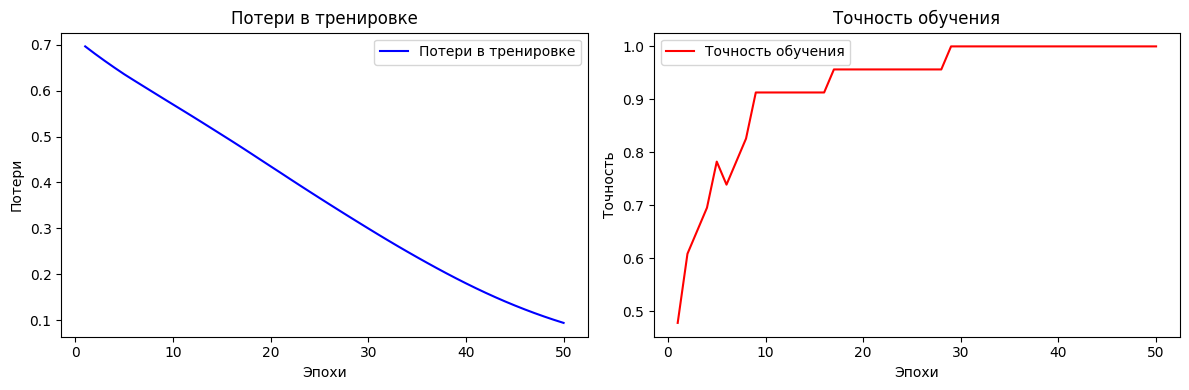

In [244]:
# Вариант обучения на несбалансированном датасете. Из исходного файла удалены только строки с пустой разметкой
# Предварительно выполнены: Загрузка и предобработка данных
# x_train - входные данные (табличные параметры из резюме)
# y_train - выходные данные (оценка пригодности)

# Создание модели
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(63,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(x_Train_01, y_Train, epochs=50, batch_size=32)

# Оценка модели
loss, accuracy = model.evaluate(x_Train_01, y_Train)
print("Потери:", loss)
print("Точность:", accuracy)

# Отрисовка графика истории обучения
plot_training_history(history)


В этом примере последний слой имеет один нейрон и функцию активации сигмоид.

Модель компилируется с оптимизатором 'adam', функцией потерь 'binary_crossentropy' (так как у нас два класса: "да" и "нет") и метрикой точности (accuracy).

Модель обучается на данных x_train и y_train в течение 50 эпох с размером пакета 32. Обученная модель оценивается на тех же данных для вычисления значения потерь и точности.

##### Проверяю предсказания этой модели 

In [245]:
# Загружаю и готовлю данные для предсказаний
# Загрузка файла.xlsx
data_pr = pd.read_excel('ДатаСет Оценка резюме 581 резюме_только да.xlsx')

In [246]:
#Убираю лишние столбцы:
fixed_df_empty = data_pr.drop(data_pr.columns[0],axis = 1)                  # Убираем первый столбец с продублированными индексами. Он нам не нужен
fixed_df_empty = fixed_df_empty.drop(fixed_df_empty.columns[0],axis = 1)     # Убираем первый столбец с датой отклика. Он нам не нужен
fixed_df_empty = fixed_df_empty.drop(fixed_df_empty.columns[0],axis = 1)    # Убираем первый столбец с ФИО. Он нам не нужен
# Вывод количества резюме и числа оставшихся признаков
print(fixed_df_empty.shape)

(11, 12)


In [125]:
# Убрать кодировку в описаниях \xa0 \n
i=0
for j in range(12):  # Для каждого из столбцов таблицы (их теперь 12)
    for i in range(fixed_df_empty.shape[0]): # По всем резюме
        if type(fixed_df_empty.values[i][j])!=float: # если данные текстовые, то заменяем фрагменты кодировки ASCII на отсутствие символов
            fixed_df_empty.values[i][j] = fixed_df_empty.values[i][j].replace("\xa0","")
            fixed_df_empty.values[i][j] = fixed_df_empty.values[i][j].replace("\n"," ") # здесь замена перевода строки на пробел

In [126]:
# Настройка названий столбцов. Избавляет от зависимости использования номера по порядку в таблице

COL_SEX_AGE     = fixed_df_empty.columns.get_loc('Пол, возраст')
COL_SALARY      = fixed_df_empty.columns.get_loc('ЗП')
COL_POS_SEEK    = fixed_df_empty.columns.get_loc('Ищет работу на должность')
COL_CITY        = fixed_df_empty.columns.get_loc('Город')
COL_EMPL        = fixed_df_empty.columns.get_loc('Занятость')
COL_SCHED       = fixed_df_empty.columns.get_loc('График')
COL_EXP         = fixed_df_empty.columns.get_loc('Опыт ()')
СOL_CUR_PL_WORK = fixed_df.columns.get_loc('Последнее/нынешное место работы')
COL_POS_PREV    = fixed_df_empty.columns.get_loc('Последняя/нынешняя должность')
COL_EDU         = fixed_df_empty.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = fixed_df_empty.columns.get_loc('Обновление резюме')
СOL_RESULT      = fixed_df_empty.columns.get_loc('Подходит - да/нет')

In [247]:
# Формирование выборки из загруженного набора данных. Назову ее тестовой

x_test, y_test = get01Data(fixed_df_empty.values) # В варианте использования функции 1
# x_test, y_test = construct_train_data(fixed_df_empty.values)  # В варианте использования функции 2



In [248]:
# Форма наборов параметров и результата
print('x_test.shape:',x_test.shape) 
print('y_test.shape:',y_test.shape)

# Пример обработанных данных
n = 10
print('Пример результата векторизации данных в строке n (x_test[n]):', x_test[n])
print('Пример результата векторизации данных в строке n (y_test[n]):', y_test[n])

x_test.shape: (11, 63)
y_test.shape: (11,)
Пример результата векторизации данных в строке n (x_test[n]): [0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0
 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Пример результата векторизации данных в строке n (y_test[n]): 1


In [249]:
# Проверка работы сети - предсказание на "тестовой" выборке
pred = model.predict(x_test)
pred

1/1 [==============================] - 0s 54ms/step


array([[0.96564245],
       [0.91835827],
       [0.9403776 ],
       [0.96744245],
       [0.940368  ],
       [0.96825314],
       [0.86401546],
       [0.7710714 ],
       [0.8524201 ],
       [0.83507043],
       [0.93835795]], dtype=float32)

In [250]:
# Для удобочитаемости: 
predictions = pred.flatten()  # Преобразование в одномерный массив
predictions = [1 if p >= 0.5 else 0 for p in predictions]  # Преобразование вероятностей в метки "да" (1) или "нет" (0)

print(predictions)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


**Все 79 предсказаний отрицательные.** 

ГИПОТЕЗА: при соотношении разметок 11/480+ , модель обучилась соответственно. Вероятно, если ДС будет сбалансированным, доля положительных предсказаний будет примерно такой же.

ПОДТВЕРЖДЕНИЕ: Попробовал подать только те 11 строк из тех, что были размечены "да".   Результат предсказания: все 11 положительные
Попробовал подать 16 случайно выбранных строк из тех, что были размечены как "нет". Результат предсказания: все 16 отрицательные.

ВЫВОД:
НС работает правильно. 

Попробую вариант обучения этой же модели но на сбалансированном датасете в 23 строки

Epoch 1/50
1/1 [==============================] - 1s 716ms/step - loss: 0.6644 - accuracy: 0.6087
Epoch 2/50
1/1 [==============================] - 0s 12ms/step - loss: 0.6423 - accuracy: 0.7391
Epoch 3/50
1/1 [==============================] - 0s 9ms/step - loss: 0.6207 - accuracy: 0.7826
Epoch 4/50
1/1 [==============================] - 0s 8ms/step - loss: 0.5998 - accuracy: 0.8696
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 0.5798 - accuracy: 0.9130
Epoch 6/50
1/1 [==============================] - 0s 10ms/step - loss: 0.5603 - accuracy: 0.9130
Epoch 7/50
1/1 [==============================] - 0s 12ms/step - loss: 0.5412 - accuracy: 0.9130
Epoch 8/50
1/1 [==============================] - 0s 9ms/step - loss: 0.5224 - accuracy: 0.9130
Epoch 9/50
1/1 [==============================] - 0s 9ms/step - loss: 0.5038 - accuracy: 0.9130
Epoch 10/50
1/1 [==============================] - 0s 8ms/step - loss: 0.4853 - accuracy: 1.0000
Epoch 11/50
1/1 [=================

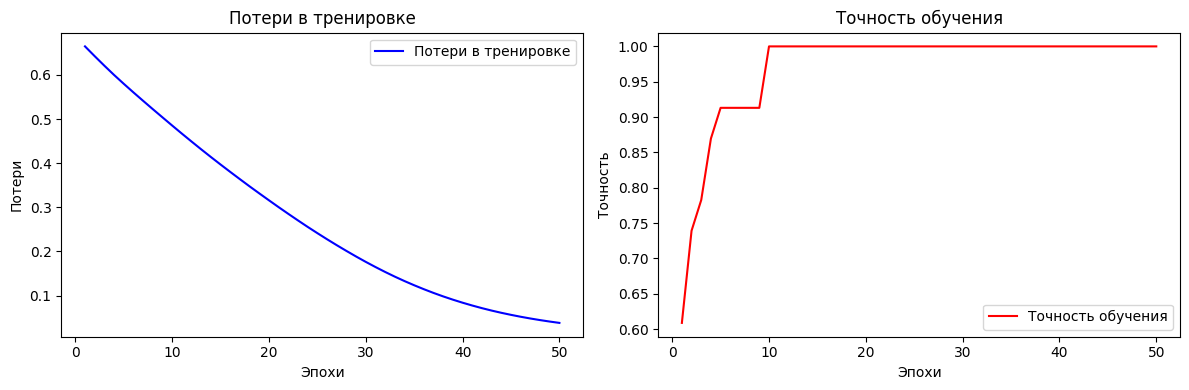

In [251]:
# Вариант обучения на сбалансированном датасете. Из исходного файла удалены все пустые разметки и разметки с "нет", кроме 12 случайных
# вариантов. Строки перемешаны с "да"


# Создание модели
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(63,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train_02, y_train, epochs=50, batch_size=32)

# Оценка модели
loss, accuracy = model.evaluate(x_train_02, y_train)
print("Потери:", loss)
print("Точность:", accuracy)

# Отрисовка графика истории обучения
plot_training_history(history)

##### Проверяю предсказание этой модели 

In [253]:
# Загружаю и готовлю неразмеченные Заказчиком данные для предсказаний
# Загрузка файла.xlsx
data_pr = pd.read_excel('ДатаСет Оценка резюме 581 резюме_пуст.xlsx')

In [254]:
#Убираю лишние столбцы:
fixed_df_empty = data_pr.drop(data_pr.columns[0],axis = 1)                  # Убираем первый столбец с продублированными индексами. Он нам не нужен
fixed_df_empty = fixed_df_empty.drop(fixed_df_empty.columns[0],axis = 1)     # Убираем первый столбец с датой отклика. Он нам не нужен
fixed_df_empty = fixed_df_empty.drop(fixed_df_empty.columns[0],axis = 1)    # Убираем первый столбец с ФИО. Он нам не нужен
# Вывод количества резюме и числа оставшихся признаков
print(fixed_df_empty.shape)

(79, 12)


In [255]:
# Убрать кодировку в описаниях \xa0 \n
i=0
for j in range(12):  # Для каждого из столбцов таблицы (их теперь 12)
    for i in range(fixed_df_empty.shape[0]): # По всем резюме
        if type(fixed_df_empty.values[i][j])!=float: # если данные текстовые, то заменяем фрагменты кодировки ASCII на отсутствие символов
            fixed_df_empty.values[i][j] = fixed_df_empty.values[i][j].replace("\xa0","")
            fixed_df_empty.values[i][j] = fixed_df_empty.values[i][j].replace("\n"," ") # здесь замена перевода строки на пробел

In [256]:
# Настройка названий столбцов. Избавляет от зависимости использования номера по порядку в таблице

COL_SEX_AGE     = fixed_df_empty.columns.get_loc('Пол, возраст')
COL_SALARY      = fixed_df_empty.columns.get_loc('ЗП')
COL_POS_SEEK    = fixed_df_empty.columns.get_loc('Ищет работу на должность')
COL_CITY        = fixed_df_empty.columns.get_loc('Город')
COL_EMPL        = fixed_df_empty.columns.get_loc('Занятость')
COL_SCHED       = fixed_df_empty.columns.get_loc('График')
COL_EXP         = fixed_df_empty.columns.get_loc('Опыт ()')
СOL_CUR_PL_WORK = fixed_df.columns.get_loc('Последнее/нынешное место работы')
COL_POS_PREV    = fixed_df_empty.columns.get_loc('Последняя/нынешняя должность')
COL_EDU         = fixed_df_empty.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = fixed_df_empty.columns.get_loc('Обновление резюме')
СOL_RESULT      = fixed_df_empty.columns.get_loc('Подходит - да/нет')

In [257]:
# Формирование выборки из загруженного набора данных. Назову ее тестовой
x_test, y_test = construct_train_data(fixed_df_empty.values)

In [258]:
# Форма наборов параметров и результата
print('x_test.shape:',x_test.shape) 
print('y_test.shape:',y_test.shape)

# Пример обработанных данных
n = 10
print('Пример результата векторизации данных в строке n (x_test[n]):', x_test[n])
print('Пример результата векторизации данных в строке n (y_test[n]):', y_test[n])

x_test.shape: (79, 63)
y_test.shape: (79,)
Пример результата векторизации данных в строке n (x_test[n]): [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
Пример результата векторизации данных в строке n (y_test[n]): 0


In [259]:
# Проверка работы сети - предсказание на тренировочной выборке
pred = model.predict(x_test)
pred

3/3 [==============================] - 0s 4ms/step


array([[0.02946672],
       [0.64635825],
       [0.15297754],
       [0.16890606],
       [0.5863945 ],
       [0.5802211 ],
       [0.6531543 ],
       [0.97452027],
       [0.88283163],
       [0.10184018],
       [0.04967462],
       [0.8691981 ],
       [0.34072462],
       [0.8582518 ],
       [0.8450374 ],
       [0.13592911],
       [0.64171946],
       [0.6031982 ],
       [0.9823704 ],
       [0.9454336 ],
       [0.14157845],
       [0.7951206 ],
       [0.7741806 ],
       [0.95368946],
       [0.7994977 ],
       [0.59656143],
       [0.28274003],
       [0.3519001 ],
       [0.9196351 ],
       [0.8821083 ],
       [0.10184018],
       [0.26856673],
       [0.90389323],
       [0.72154677],
       [0.8450374 ],
       [0.7122237 ],
       [0.89564234],
       [0.5522526 ],
       [0.12357853],
       [0.7160174 ],
       [0.70055616],
       [0.10396966],
       [0.05435321],
       [0.3313963 ],
       [0.00874607],
       [0.01738291],
       [0.07569323],
       [0.047

In [260]:
# Для удобочитаемости: 
predictions = pred.flatten()  # Преобразование в одномерный массив
predictions = [1 if p >= 0.5 else 0 for p in predictions]  # Преобразование вероятностей в метки "да" (1) или "нет" (0)

print(predictions)

[0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]


In [261]:
sum(predictions)

46

##### Результаты/выводы

До ввода в состав обучающей выборки данных о целевой должности соискателя и после, обученнная модель дает несколько разные результаты:

ДО:

  На несбалансированонм ДС:

     - на новых (неразмеченных Заказчиком) данных: все отрицательные предсказания.
     
  На сбалансированном ДС в 23 строки:

     - на новых (неразмеченных Заказчиком) данных:
     доля положительных чуть менее половины (36/79), что соотвтетствует соотношению долей положительных и отризательных разметок;
     
ПОСЛЕ: 

  На несбалансированном ДС:

     - на новых данных (неразмеченныз данных):
     все отрицательные предсказания.
     - на заведомо положительных (на входе только "да"): все положительные предсказания.
     - на заведомо отрицательных (на входе только "нет"): все отрицательные предсказания.
      
  На сбалансированном ДС:
  
     - на новых данных: доля положительных предсказаний 43/79  (выросла)
     - на заведомо положительных: все положительные (так же)
     - на заведомо отрицательных: 9 положительных из 16 (!). 


ВЫВОДЫ: 
1. На сбалансированном ДС НС дает пропорционально сбалансированные результаты предсказаний.

2. В состав поданных в НС данных не вошли какие-то, принимаемые Заказчиком во внимание при разметке. Поэтому нужно дополнить входящий вектор ранее не оцифрованными данными для повыщения точности предсказаний.



#### Модель НС для простых текстовых данных

Epoch 1/50
1/1 [==============================] - 1s 554ms/step - loss: 0.5926 - mae: 0.5925 - val_loss: 0.1675 - val_mae: 0.1696
Epoch 2/50
1/1 [==============================] - 0s 37ms/step - loss: 0.5884 - mae: 0.5896 - val_loss: 0.1665 - val_mae: 0.1685
Epoch 3/50
1/1 [==============================] - 0s 64ms/step - loss: 0.5847 - mae: 0.5877 - val_loss: 0.1656 - val_mae: 0.1689
Epoch 4/50
1/1 [==============================] - 0s 61ms/step - loss: 0.5812 - mae: 0.5865 - val_loss: 0.1647 - val_mae: 0.1706
Epoch 5/50
1/1 [==============================] - 0s 99ms/step - loss: 0.5779 - mae: 0.5859 - val_loss: 0.1639 - val_mae: 0.1725
Epoch 6/50
1/1 [==============================] - 0s 70ms/step - loss: 0.5747 - mae: 0.5853 - val_loss: 0.1632 - val_mae: 0.1742
Epoch 7/50
1/1 [==============================] - 0s 51ms/step - loss: 0.5717 - mae: 0.5848 - val_loss: 0.1624 - val_mae: 0.1759
Epoch 8/50
1/1 [==============================] - 0s 95ms/step - loss: 0.5688 - mae: 0.5843 - va

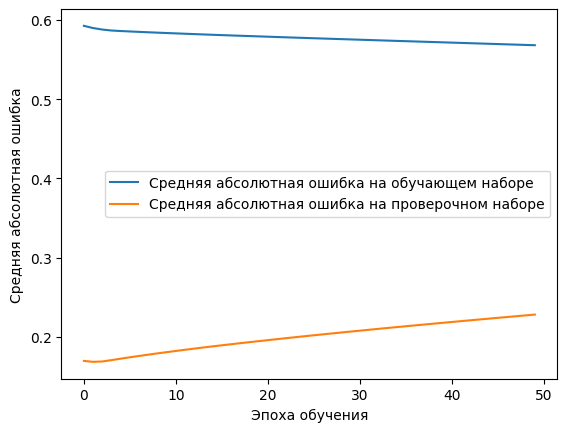

In [263]:
# Предсказываем пригодность по текущему месту работы и должности
modelTProf = Sequential()
modelTProf.add(Dense(20, activation='relu', input_dim=(xTrainProf01.shape[1]) ) )
modelTProf.add(Dense(500, activation='relu'))
modelTProf.add(Dense(1, activation='linear'))

modelTProf.compile(optimizer=Adagrad(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = modelTProf.fit(xTrainProf01[:17], # В ДС всего 500 резюме. на проверочную отдам 75 или 15%
                    y_train[:17], 
                    batch_size=20,
                    epochs=50, 
                    #validation_split=0.1, 
                    validation_data=(xTrainProf01[17:], y_train[17:]),
                    verbose=1, shuffle=True)

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [62]:
# del xTrainProf01 # Удаление  переменной при риске нехватки памяти (для данного ДС неактуально)

Вывод: при работе с сильно несбалансированным ДС не стоило ожидать чего то путного

На сбалансированном, но малом ДС - переобучение

#### Модель для сложных текстовых данных

Epoch 1/20
22/22 [==============================] - 1s 11ms/step - loss: 0.3243 - mae: 0.4883 - val_loss: 0.2851 - val_mae: 0.5094
Epoch 2/20
22/22 [==============================] - 0s 5ms/step - loss: 0.2441 - mae: 0.4765 - val_loss: 0.2601 - val_mae: 0.5037
Epoch 3/20
22/22 [==============================] - 0s 6ms/step - loss: 0.2068 - mae: 0.4390 - val_loss: 0.2652 - val_mae: 0.5032
Epoch 4/20
22/22 [==============================] - 0s 6ms/step - loss: 0.1804 - mae: 0.3981 - val_loss: 0.2917 - val_mae: 0.5065
Epoch 5/20
22/22 [==============================] - 0s 5ms/step - loss: 0.1566 - mae: 0.3560 - val_loss: 0.2893 - val_mae: 0.5103
Epoch 6/20
22/22 [==============================] - 0s 6ms/step - loss: 0.1382 - mae: 0.3187 - val_loss: 0.3064 - val_mae: 0.5213
Epoch 7/20
22/22 [==============================] - 0s 5ms/step - loss: 0.1200 - mae: 0.2835 - val_loss: 0.3067 - val_mae: 0.5179
Epoch 8/20
22/22 [==============================] - 0s 6ms/step - loss: 0.1045 - mae: 0.2

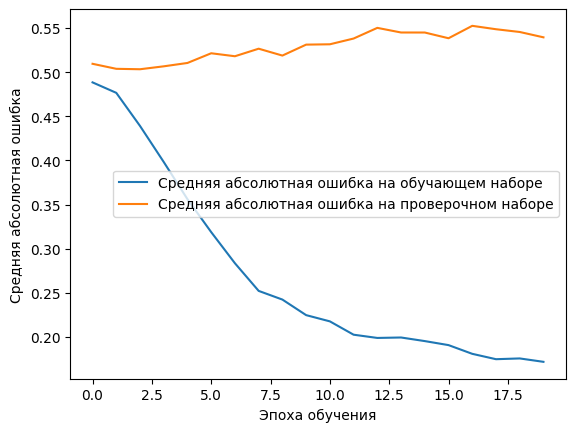

In [191]:
# Предсказываем пригодность по данным об образовании
# здесь в параметрах maxWordCount = 5000
modelTRez = Sequential()
modelTRez.add(Dense(20, activation='relu',input_dim=(xTrainEduc01.shape[1])))
modelTRez.add(Dense(500, activation='relu'))
modelTRez.add(Dropout(0.3))                             # этим слоем модель отличается от предыдущей
modelTRez.add(Dense(1, activation='linear'))
 
modelTRez.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
 
history = modelTRez.fit(xTrainEduc01[:425], 
                    y_train[:425], 
                    batch_size=20,
                    epochs=20, 
                    validation_data=(xTrainEduc01[425:], y_train[425:]),
                    verbose=1, shuffle=True)
 
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

Вывод: На этом несбалансированном датасете не стоит ожидать путных результатов

На малом количестве данных - переобучение

### Не адаптированные модели 

#### Вариант 2  для таличных данных (предложен ChatGPT)

Для задачи регрессии по описанному датасету с табличными данными из резюме кандидатов, можно рассмотреть использование следующей модели нейронной сети:
Модель: Многослойный перцептрон (Multilayer Perceptron, MLP)
Многослойный перцептрон (MLP) является одним из базовых типов нейронных сетей. Он состоит из нескольких слоев нейронов, включая входной слой, скрытые слои и выходной слой. Каждый нейрон в слоях связан с нейронами в следующем слое и обрабатывает входные данные с помощью активационной функции.
Пример кода для создания модели MLP с использованием библиотеки Keras:


In [ ]:
#  Вариант предложенный Chat GPT:


# Определение модели MLP
model = Sequential()
model.add(Dense(64, input_dim=57, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Компиляция модели
model.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
model.fit(x_train_02, y_train, epochs=100, batch_size=32)

# Оценка модели
mse = model.evaluate(x_test, y_test)


NameError: ignored

В этом примере модель состоит из трех слоев: входного слоя с 10 нейронами, двух скрытых слоев с 64 нейронами каждый и выходного слоя с одним нейроном. В качестве функции активации используется ReLU для скрытых слоев и линейная функция активации для выходного слоя.
Модель компилируется с использованием функции потерь "mean_squared_error" (средняя квадратичная ошибка) и оптимизатора "adam". Затем модель обучается на тренировочных данных с заданным количеством эпох и размером пакета.
В конце модель оценивается на тестовых данных, и среднеквадратичная ошибка (MSE) используется для оценки производительности модели.
Вы можете настроить параметры модели, такие как количество скрытых слоев, количество нейронов в каждом слое, функции активации и оптимизатор, чтобы достичь оптимальных результатов в вашей конкретной задаче.


#### Вариант 3 для табличных данных из обучающего ноутбука от Кузина С.

##### Нейронка по простым данным

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=964

Epoch 1/50
2/2 [==============================] - 1s 201ms/step - loss: 0.8918 - mae: 0.7673 - val_loss: 0.0437 - val_mae: 0.2064
Epoch 2/50
2/2 [==============================] - 0s 42ms/step - loss: 0.1544 - mae: 0.3029 - val_loss: 0.0071 - val_mae: 0.0831
Epoch 3/50
2/2 [==============================] - 0s 46ms/step - loss: 0.1262 - mae: 0.2844 - val_loss: 0.0048 - val_mae: 0.0680
Epoch 4/50
2/2 [==============================] - 0s 41ms/step - loss: 0.0744 - mae: 0.1964 - val_loss: 3.2709e-04 - val_mae: 0.0143
Epoch 5/50
2/2 [==============================] - 0s 40ms/step - loss: 0.0251 - mae: 0.0748 - val_loss: 0.0030 - val_mae: 0.0524
Epoch 6/50
2/2 [==============================] - 0s 46ms/step - loss: 0.0279 - mae: 0.1099 - val_loss: 0.0045 - val_mae: 0.0657
Epoch 7/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0338 - mae: 0.1417 - val_loss: 0.0043 - val_mae: 0.0644
Epoch 8/50
2/2 [==============================] - 0s 50ms/step - loss: 0.0319 - mae: 0.1350 

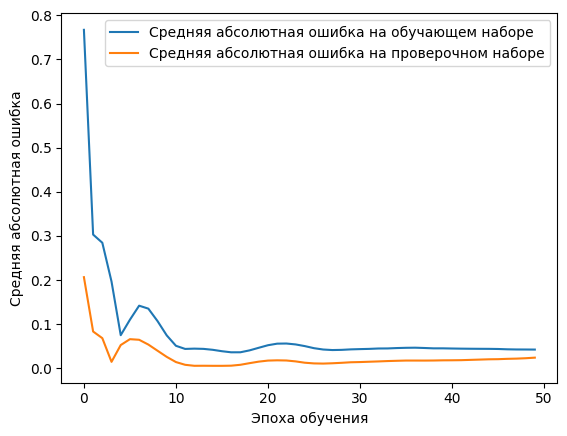

In [ ]:
# Обучаем модель полученными данными
model = Sequential()
model.add(BatchNormalization(input_shape=(x_Train_01.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1000, activation='tanh'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])

history = model.fit(x_Train_01, 
                    y_Train, 
                    epochs=50, 
                    batch_size=256,
                    validation_split=0.015, 
                    verbose=1)

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()


In [ ]:
# Проверка работы сети - предсказание на "тестовой" выборке
pred = model.predict(x_test)
# Для удобочитаемости: 
predictions = pred.flatten()  # Преобразование в одномерный массив
predictions = [1 if p >= 0.5 else 0 for p in predictions]  # Преобразование вероятностей в метки "да" (1) или "нет" (0)
print(pred)
print(predictions)

1/1 [==============================] - 0s 87ms/step
[[0.16954209]
 [0.05355111]
 [0.11302847]
 [0.07704078]
 [0.09645788]
 [0.18447512]
 [0.10768918]
 [0.14034578]
 [0.17008413]
 [0.21974348]
 [0.16537598]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Делаем предсказание и приводим его к начальному виду
pred = model.predict(xTrain01)
pred = pred.flatten()
# Среднее значение ошибки 
delta = pred - yTrain
absDelta = abs(delta)
print(sum(absDelta) / len(absDelta))

In [ ]:
# В качестве нормализации данных используем готовую библиотеку 
yScaler = StandardScaler()

# Скармливаем объекту двумерный вектор
yScaler.fit(yTrain.reshape(-1, 1))

# Нормализуем по нормальному распределению
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))

print(yTrainScaled.shape)
print(yTrain[1])
print(yTrainScaled[1])

In [ ]:
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

In [ ]:
# Обучаем модель стандартизированными данными
modelS = Sequential()
modelS.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
modelS.add(Dense(128, activation='relu'))
modelS.add(Dense(1000, activation='tanh'))
modelS.add(Dense(100, activation='relu'))
modelS.add(Dense(1, activation='linear'))

modelS.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])

history = modelS.fit(xTrain01, 
                    yTrainScaled, 
                    epochs=50, 
                    batch_size=64,
                    validation_split=0.15, 
                    verbose=2)

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
# Делаем предсказание и приводим его к начальному виду
pred = modelS.predict(xTrain01)
predUnscaled = yScaler.inverse_transform(pred).flatten()

# Среднее значение ошибки 
delta = predUnscaled - yTrain
absDelta = abs(delta)
print(sum(absDelta) / len(absDelta))

##### Оценка результатов

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=1314



In [ ]:
yy = model.predict(xTrain01) # Результат для всего тренировочного набора

In [ ]:
n = 10
for i in range(n):
  print('Реальное значение - ',yTrain[i], " Предсказанное значение - ", yy[i][0], " Разница - ", abs(yTrain[i]-yy[i][0]))

Примерный план подготовительных шагов в подготовке данных для обучения модели:

1. Задать понятные названия столбцам для использования в коде без индексов.

2. Предобработка данных: Проверить данные на наличие пропущенных значений и выбросов. Может потребоваться заполнить пропущенные значения или удалить аномальные данные. Также может потребоваться выполнить масштабирование или нормализацию признаков, чтобы обеспечить стабильность обучения модели.

3. Разделение на тренировочный и тестовый наборы. Обычно используется отношение 80/20 или 70/30. 

4. Кодирование целевой переменной: Поскольку целевая переменная ("подходит" или "не подходит") представлена в виде текстовых меток, потребуется кодирование для преобразования ее в числовой формат. Например, можно присвоить числу 1 для "подходит" и числу 0 для "не подходит".

5. Обработка дисбаланса классов: Исходная БД очень несбалансирована. Возможно, боевая будет получше. Если нет, потребуется изучить и, возможно,  применить методы балансировки классов, такие как взвешивание классов или аугментация текстовых/табличных данных, чтобы предотвратить смещение модели в сторону преобладающего класса. 

6. Гиперпараметры и кросс-валидация: Нужно определить оптимальные значения гиперпараметров модели, такие как количество нейронов, количество слоев, скорость обучения и другие. Нужно изучить и попробовать использовать методы кросс-валидации для оценки производительности модели на различных подмножествах данных и выбора лучших параметров.

7. Проверка настройки модели в соответствии с требованиями к точности предсказаний и обработанными данными перед началом обучения на обещанных боевых данных от Заказчика.

8. Сборка фрейма предобработки данных от Заказчика для подачи на обучение модели и для дообучения на новых данных, поступающих от заказчика в будущем

## Составная НС

Пробую собрать связку из 3 НС:
 - НС для работы с табличными данными по соискателю (вход 1)
 - НС для работы с текстом об текущем месте работы (вход 2)
 - НС для рабты с текстом об образовании (вход 3)

In [264]:
input1 = Input((x_train_02.shape[1],))                # обучающая выборка по табличным данным в варианте сборки вектора № 2
input2 = Input((xTrainProf01.shape[1],))              # обучающая выборка по тестовым данным об текущем месте работы
input3 = Input((xTrainEduc01.shape[1],))              # обучающая выборка по текстовым данным об образовании

x1 = BatchNormalization()(input1) # Создаем ветку х1
x1 = Dropout(0.5)(x1)
x1 = Dense(10, activation="relu")(x1)
x1 = Dense(1000, activation="relu")(x1)
x1 = Dense(100, activation = "relu")(x1)

x2 = BatchNormalization()(input2) # Создаем ветку х2
x2 = Dense(25, activation="relu")(input2)
x2 = Dense(8, activation="tanh")(x2)
x2 = Dense(5, activation = "elu")(x2)

x3 = BatchNormalization()(input3) # Создаем ветку х3
x3 = Dense(1000, activation="tanh")(input3)
x3 = Dense(20, activation = "elu")(x3)
x3 = Dense(5, activation = "elu")(x3)

x = concatenate([x1, x2, x3]) # Объединяем все три ветки

x = Dense(15, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='relu')(x) # Финальный нейрон, делает регрессию

model = Model((input1, input2, input3), x) # В Model загружаем стартовые и последнюю точки 

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model.fit([x_train_02[:17], xTrainProf01[:17], xTrainEduc01[:17]],  # первые 425/17 строк ДС
                    y_train[:17], 
                    epochs= 80, 
                    validation_data=([x_train_02[17:], xTrainProf01[17:], xTrainEduc01[17:]], # последние 75/6 строк
                    y_train[17:]), 
                    verbose=1, shuffle=True)

Epoch 1/80
1/1 [==============================] - 4s 4s/step - loss: 0.5882 - mae: 0.5882 - val_loss: 0.1667 - val_mae: 0.1667
Epoch 2/80
1/1 [==============================] - 0s 115ms/step - loss: 0.5858 - mae: 0.5870 - val_loss: 0.1667 - val_mae: 0.1667
Epoch 3/80
1/1 [==============================] - 0s 109ms/step - loss: 0.5783 - mae: 0.5910 - val_loss: 0.1667 - val_mae: 0.1667
Epoch 4/80
1/1 [==============================] - 0s 105ms/step - loss: 0.5674 - mae: 0.5767 - val_loss: 0.1667 - val_mae: 0.1667
Epoch 5/80
1/1 [==============================] - 0s 106ms/step - loss: 0.4585 - mae: 0.5229 - val_loss: 0.1667 - val_mae: 0.1684
Epoch 6/80
1/1 [==============================] - 0s 101ms/step - loss: 0.5032 - mae: 0.5801 - val_loss: 0.1575 - val_mae: 0.1916
Epoch 7/80
1/1 [==============================] - 0s 111ms/step - loss: 0.5689 - mae: 0.6899 - val_loss: 0.1522 - val_mae: 0.2081
Epoch 8/80
1/1 [==============================] - 0s 97ms/step - loss: 0.4151 - mae: 0.5371 -

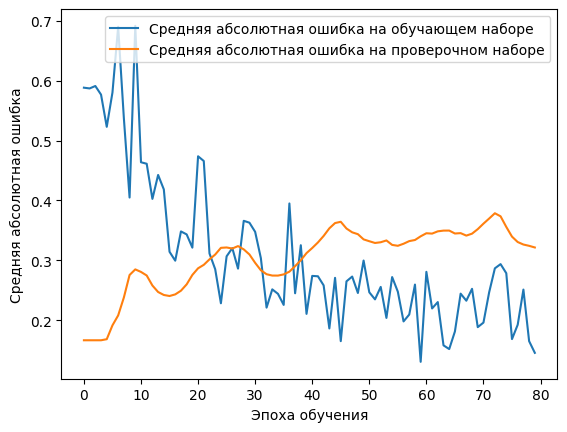

In [265]:
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

Для работы нужен нормальный ДС